In [2]:
# --- IMPORTS ---
import re
import string
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

# --- DATA CLEANING ---

source = 'monolingual.hi'   # <<< After uploading your .hi file, put path here
output = 'text.clean'

def remove_latin(text):
    text = re.sub(r'[a-zA-Z]', '', text)
    return text

def remove_punctuation(text):
    hindi_punctuations =  '''`÷×؛<>_()*&^%][ـ،:"؟.,'{}~¦+|!”…“–ـ/$£•●'''
    english_punctuations = string.punctuation
    numbers = "1234567890०१२३४५६७८९।"
    bad_characters = "�¿áóóó□"
    punctuations_list = hindi_punctuations + english_punctuations + numbers +  bad_characters
    text = text.translate(str.maketrans('/', ' ', ''))
    text = text.translate(str.maketrans('', '', punctuations_list))
    return text

def add_noise(text, noise_factor=0.1):
    words = text.split()
    noisy_words = []
    for word in words:
        if np.random.rand() < noise_factor:
            noisy_words.append(''.join(np.random.choice(list(word), len(word))))
        else:
            noisy_words.append(word)
    return ' '.join(noisy_words)

with open(source, encoding='utf-8') as f:
    text = f.read()

text = re.split(r'\. |\.\n|\!\n|\؟\n|\n', text)
text = list(set(text))

with open(output, "w+", encoding='utf-8') as clean:
    for segment in text:
        segment = segment.strip()
        segment = remove_punctuation(segment)
        segment = remove_latin(segment)
        segment = segment.strip()
        segment = " ".join(segment.split())                   
        segment = " ".join(segment.split()[:15])
        if segment != "" and len(segment.split()) > 3:
            segment = "<s> " + segment
            if ord(u'\u0900') <= ord(segment[4]) <= ord(u'\u097F'):
                clean.write(segment + "\n")

print("Done cleaning.")

Done cleaning.


In [4]:

# --- LOAD CORPUS ---

data = open(output, encoding='utf-8').read()
corpus = data.lower().split("\n")
print(f"Sample line: {corpus[0]}")

Sample line: <s> मैने बिना देर किये अपने लुनद को तेल के दिबे मे दुबया और उसे अदिती


In [5]:
# --- CHARACTER-LEVEL TOKENIZER ---

class CharTokenizer:
    def __init__(self, texts):
        chars = set("".join(texts))
        self.special_tokens = ['<pad>', '<sos>', '<eos>']
        self.char2idx = {ch: i + len(self.special_tokens) for i, ch in enumerate(sorted(chars))}
        for i, token in enumerate(self.special_tokens):
            self.char2idx[token] = i
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}

    def encode(self, text, max_len):
        tokens = ['<sos>'] + list(text) + ['<eos>']
        tokens = tokens[:max_len]
        tokens += ['<pad>'] * (max_len - len(tokens))
        return [self.char2idx[t] for t in tokens]

    def decode(self, ids):
        return ''.join([self.idx2char[i] for i in ids if self.idx2char[i] not in ['<pad>', '<sos>', '<eos>']])

    def vocab_size(self):
        return len(self.char2idx)

tokenizer = CharTokenizer(corpus)

In [6]:
# --- GLOVE EMBEDDINGS ---

def load_glove_embeddings(glove_file='glove.6B.50d.txt'):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings()


In [7]:
# --- DATASET ---

class DPCSpellDataset(Dataset):
    def __init__(self, corpus, tokenizer, max_len=32):
        self.corpus = corpus
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, idx):
        text = self.corpus[idx]
        input_ids = torch.tensor(self.tokenizer.encode(text, self.max_len))
        target_ids = torch.tensor(self.tokenizer.encode(text, self.max_len))
        return input_ids, target_ids

dataset = DPCSpellDataset(corpus, tokenizer)

train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)


In [8]:
# --- POS ENCODING ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        return x + self.pe[:x.size(0), :].to(x.device)


In [9]:
# --- TRANSFORMER MODEL ---

class DPCSpellTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4, max_len=32, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=1024, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward=1024, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src = self.embedding(src).transpose(0, 1)
        tgt = self.embedding(tgt).transpose(0, 1)
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        return self.fc_out(output.transpose(0, 1))

model = DPCSpellTransformer(vocab_size=tokenizer.vocab_size()).cuda()

# --- LOSS, OPTIMIZER ---

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(log_probs).scatter_(1, target.data.unsqueeze(1), confidence)
        true_dist += self.smoothing / (pred.size(1) - 1)
        return nn.functional.kl_div(log_probs, true_dist, reduction='batchmean')

criterion = LabelSmoothingLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
# --- TRAINING LOOP ---

losses = []
for epoch in range(10):
    model.train()
    total_loss = 0
    for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        src, tgt = src.cuda(), tgt.cuda()
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        output = model(src, tgt_input)
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

# --- SAVE MODEL ---
save_dir = "./saved_model"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "dpcspell_transformer.pt"))
with open(os.path.join(save_dir, "char_tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)

Epoch 10: 100%|██████████| 58294/58294 [22:50<00:00, 42.52it/s]


Evaluating: 100%|██████████| 7287/7287 [09:40<00:00, 12.55it/s]


{'Accuracy': 0.9995550528307753, 'BLEU Score': 0.9999394439135068, 'Avg Levenshtein Distance': 0.0009574405352231973, 'Exact Match Ratio': 0.9995550528307753, 'Precision': 0.9999684158233892, 'Recall': 0.9999684158233892, 'F1 Score': 0.9999684158233892}


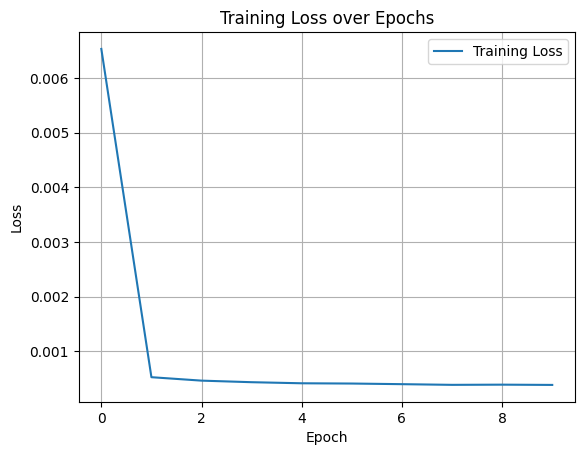

In [11]:
# --- EVALUATION ---

model.eval()
y_true, y_pred = [], []
bleu_scores, levenshtein_scores, exact_match = [], [], 0
smoothie = SmoothingFunction().method4
all_true_chars, all_pred_chars = [], []

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

with torch.no_grad():
    for src, tgt in tqdm(test_loader, desc="Evaluating"):
        src, tgt = src.cuda(), tgt.cuda()
        outputs = model(src, tgt[:, :-1])
        predicted_ids = outputs.argmax(dim=-1)
        
        for pred_ids, true_ids in zip(predicted_ids, tgt[:, 1:]):
            pred = tokenizer.decode(pred_ids.tolist()).strip()
            true = tokenizer.decode(true_ids.tolist()).strip()
            
            y_pred.append(pred)
            y_true.append(true)

            bleu_scores.append(sentence_bleu([true], pred, smoothing_function=smoothie))
            levenshtein_scores.append(levenshtein_distance(pred, true))
            
            if pred == true:
                exact_match += 1

            max_len = max(len(true), len(pred))
            true_padded = true.ljust(max_len)
            pred_padded = pred.ljust(max_len)

            all_true_chars.extend(list(true_padded))
            all_pred_chars.extend(list(pred_padded))

# --- METRICS ---
accuracy = accuracy_score(y_true, y_pred)
avg_bleu = np.mean(bleu_scores)
avg_lev = np.mean(levenshtein_scores)
exact_match_ratio = exact_match / len(y_true)
precision = precision_score(all_true_chars, all_pred_chars, average='micro', zero_division=0)
recall = recall_score(all_true_chars, all_pred_chars, average='micro', zero_division=0)
f1 = f1_score(all_true_chars, all_pred_chars, average='micro', zero_division=0)

print({
    "Accuracy": accuracy,
    "BLEU Score": avg_bleu,
    "Avg Levenshtein Distance": avg_lev,
    "Exact Match Ratio": exact_match_ratio,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# --- PLOT TRAINING LOSS ---
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


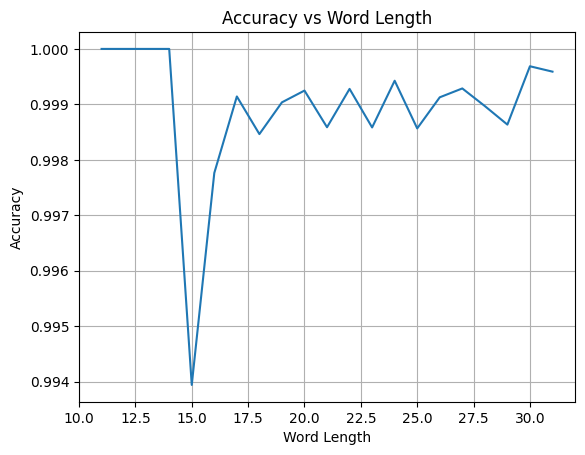

In [14]:
import pandas as pd

lengths = [len(x) for x in y_true]
correct = [int(p == t) for p, t in zip(y_pred, y_true)]

df = pd.DataFrame({'length': lengths, 'correct': correct})
length_acc = df.groupby('length')['correct'].mean()

length_acc.plot()
plt.title('Accuracy vs Word Length')
plt.xlabel('Word Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [15]:
import random

mistakes = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
sample_mistakes = random.sample(mistakes, min(10, len(mistakes)))

for true, pred in sample_mistakes:
    print(f"True : {true}")
    print(f"Pred : {pred}")
    print('-' * 30)


True : <s> यह बात मुख्यमंत्री शिवराज ¨
Pred : <s> यह बात मुख्यमंत्री शिवराज ऒ
------------------------------
True : <s> सभी विषम भाजक हैं ≡
Pred : <s> सभी विषम भाजक हैं भ
------------------------------
True : <s> जो नवाब نواب का बहुवचन होता
Pred : <s> जो नवाब نااي का बहुवचन होता
------------------------------
True : <s> मुख पृष्ठ »हमारे बारे में ›
Pred : <s> मुख पृष्ठ »हमारे बारे में ​
------------------------------
True : <s> लेकिन उनके आकस्मिक नि  धन
Pred : <s> लेकिन उनके आकस्मिक नि   धन
------------------------------
True : <s> चार मीनार तेलुगु చ ా ర ్ మ
Pred : <s> चार मीनार तेलुगु ن म ﾵ ग ﾵ
------------------------------
True : <s> गम्भीर हा ¶ त में मरणासन्न
Pred : <s> गम्भीर हा  त में मरणासन्न
------------------------------
True : <s> एस सी टी सी† · हैदराबाद उच्
Pred : <s> एस सी टी सीﾵ · हैदराबाद उच्
------------------------------
True : <s> इसी राष्टﾦवाद ने साम्राज्यव
Pred : <s> इसी राष्टवाद ने साम्राज्यव
------------------------------
True : <s> एक खेत जिसके किनारे रेमन≈
Pred

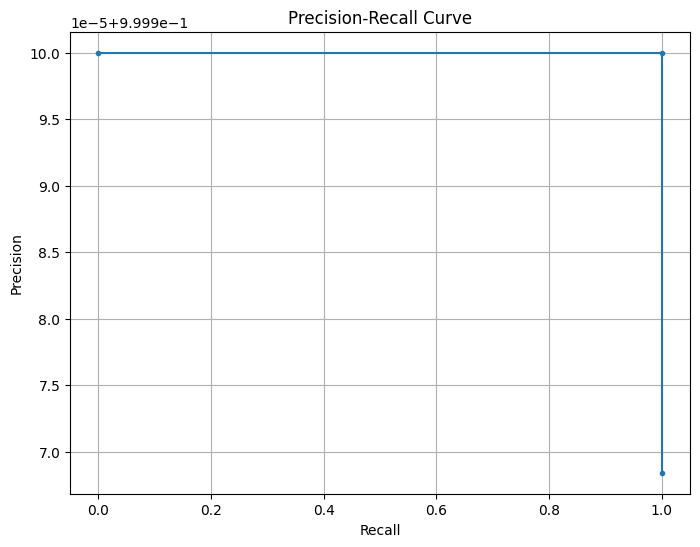

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true_binary = [1 if t == p else 0 for t, p in zip(all_true_chars, all_pred_chars)]
y_scores_binary = [1 if t == p else 0 for t, p in zip(all_true_chars, all_pred_chars)]  # Model is very confident (hard labels)

precision, recall, _ = precision_recall_curve(y_true_binary, y_scores_binary)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


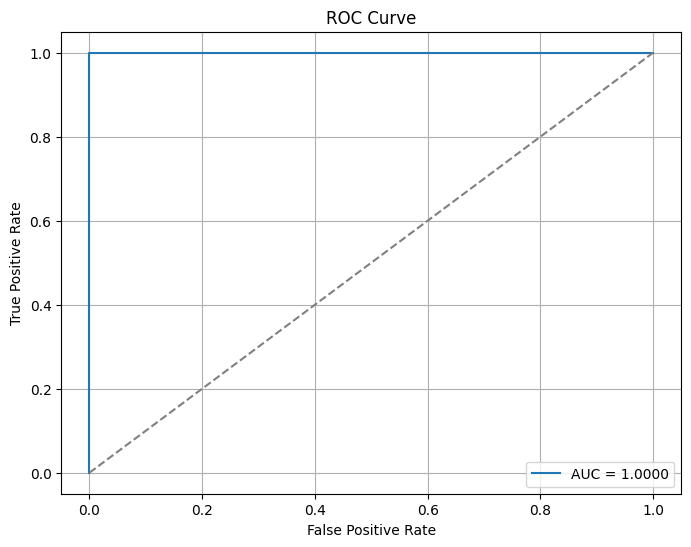

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_binary, y_scores_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_losses' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(exact_match_ratios, label='Exact Match Ratio')
plt.title('Exact Match Ratio Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Exact Match Ratio')
plt.legend()
plt.grid(True)
plt.show()


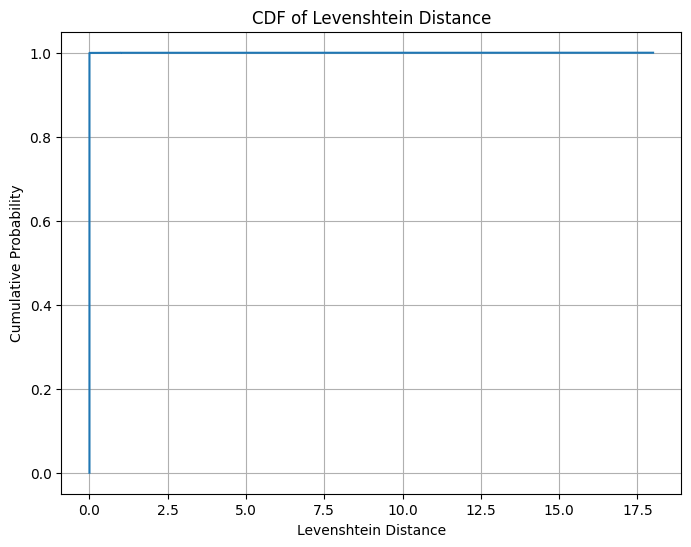

In [39]:
import numpy as np

lev_sorted = np.sort(levenshtein_scores)
cdf = np.arange(len(lev_sorted)) / float(len(lev_sorted))

plt.figure(figsize=(8,6))
plt.plot(lev_sorted, cdf)
plt.title('CDF of Levenshtein Distance')
plt.xlabel('Levenshtein Distance')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


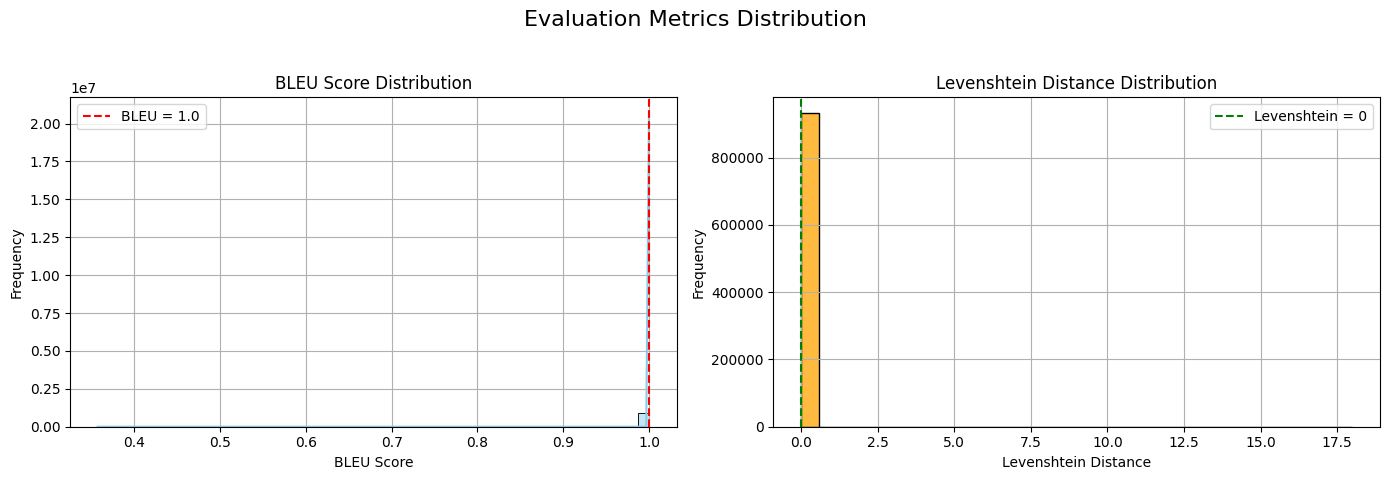

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- BLEU Score Distribution ---
sns.histplot(bleu_scores, kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].axvline(x=1.0, color='red', linestyle='--', label='BLEU = 1.0')
axes[0].set_title('BLEU Score Distribution')
axes[0].set_xlabel('BLEU Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True)

# --- Levenshtein Distance Distribution ---
sns.histplot(levenshtein_scores, kde=False, bins=30, color='orange', ax=axes[1])
axes[1].axvline(x=0, color='green', linestyle='--', label='Levenshtein = 0')
axes[1].set_title('Levenshtein Distance Distribution')
axes[1].set_xlabel('Levenshtein Distance')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Evaluation Metrics Distribution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
